# W207 Final Project: Random Acts of Pizza

#### By:  David Skarbrevik, Jayashree Ramen, and Nikki Haas
#### MIDS W207:  Intro to Machine Learning
#### University of California, Berkeley
#### Spring, 2017

# Importing libraries

In [2]:
#some of the SKLearn features we learnt in class are being depreciated.  They still exist for now, so let's ignore 
#the watnings
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

#General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import json
import pandas as pd
import os
import xgboost as xgb
import datetime
import image
from subprocess import check_output
from matplotlib import pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MaxAbsScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

#SkLearn construction items
from scipy.sparse.csr import csr_matrix
from scipy.sparse import hstack


%matplotlib inline
import sys
print(sys.version)

3.5.2 |Anaconda 4.3.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


# Cleaning / Manipulating the Data / EDA / Feature Engineering

In [3]:
### data needed:
#binarized categorical data: df6_data 
#numeric data: num_data
#numeric data cannot be used as is.  
#Take num_data and normalize all fields
#text data:  data_set
#text data's pipeline masks some of the data, let's redo the Tf-Idf vectorization

train_data = pd.read_json('train.json', orient='columns')
train_labels = train_data['requester_received_pizza']
test_data = pd.read_json('test.json', orient='columns')

print("All Features in Training Data")
for x,y in enumerate(train_data.columns):
    print(x,y)

print("\n")

print("All Features in Test Data (fewer than Training Data)")
for x,y in enumerate(test_data.columns):
    print(x,y)


All Features in Training Data
0 giver_username_if_known
1 number_of_downvotes_of_request_at_retrieval
2 number_of_upvotes_of_request_at_retrieval
3 post_was_edited
4 request_id
5 request_number_of_comments_at_retrieval
6 request_text
7 request_text_edit_aware
8 request_title
9 requester_account_age_in_days_at_request
10 requester_account_age_in_days_at_retrieval
11 requester_days_since_first_post_on_raop_at_request
12 requester_days_since_first_post_on_raop_at_retrieval
13 requester_number_of_comments_at_request
14 requester_number_of_comments_at_retrieval
15 requester_number_of_comments_in_raop_at_request
16 requester_number_of_comments_in_raop_at_retrieval
17 requester_number_of_posts_at_request
18 requester_number_of_posts_at_retrieval
19 requester_number_of_posts_on_raop_at_request
20 requester_number_of_posts_on_raop_at_retrieval
21 requester_number_of_subreddits_at_request
22 requester_received_pizza
23 requester_subreddits_at_request
24 requester_upvotes_minus_downvotes_at_reque

### Getting Binarized Categorical Data

In [4]:
def day_time(x):
    y = ''
    if datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 10:
        y = 'morning'
    elif datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour >= 10 and datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 16:
        y = 'midday'
    elif datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour >= 16 and datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 21:
        y = 'evening'
    else: 
        y = 'late_night'
    return y

day_values = ['morning', 'midday', 'evening', 'late_night']
    
def human_time(a):
    import datetime
    from datetime import date
    import calendar
    ### for the data in raop, return human time.  maybe the time of day matters
    a['human_readable_local_time'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).strftime('%Y-%m-%d %H:%M:%S')
    a['human_readable_UTC_time'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request_utc']).strftime('%Y-%m-%d %H:%M:%S')
    a['weekday'] = calendar.day_name[datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).weekday()].lower()
    a['month'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).strftime("%B").lower()
    a['time_of_day'] = day_time(a)
    return a

a = pd.read_json('train.json')
b = a.apply(human_time, axis=1)
c = pd.read_json('test.json')
d = c.apply(human_time, axis =1) 

#parse the training set to match the testing set's columns
df = b[list(d.columns)]
tstdf = d[list(d.columns)]

b = pd.get_dummies(df['weekday'])
tstb = pd.get_dummies(tstdf['weekday'])
c = pd.get_dummies(df['time_of_day'])
tstc = pd.get_dummies(tstdf['time_of_day'])
d= pd.get_dummies(df['month'])
tstd= pd.get_dummies(tstdf['month'])
df2 = pd.concat([df,b,c,d], axis=1)
tstdf2 = pd.concat([tstdf,tstb,tstc,tstd], axis=1)

del df2['month']
del tstdf2['month']
del df2['weekday']
del tstdf2['weekday']
del df2['time_of_day']
del tstdf2['time_of_day']

df4 = pd.get_dummies(df2['requester_subreddits_at_request'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
tstdf4 = pd.get_dummies(tstdf2['requester_subreddits_at_request'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)



df2 = df2[[ 'request_id','friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'evening', 'late_night', 'midday', 'morning', 'april', 'august',
       'december', 'february', 'january', 'july', 'june', 'march', 'may',
       'november', 'october', 'september']]
tstdf2 = tstdf2[[ 'request_id','friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'evening', 'late_night', 'midday', 'morning', 'april', 'august',
       'december', 'february', 'january', 'july', 'june', 'march', 'may',
       'november', 'october', 'september']]

df5 = pd.concat([a['requester_received_pizza'],df2,df4], axis = 1)
tstdf5 = pd.concat([tstdf2,tstdf4], axis = 1)

del df5['request_id']
del tstdf5['request_id']

df6_labels = df5['requester_received_pizza']
del df5['requester_received_pizza']
df6_data = df5

bincat_train_data = df6_data[0:2019]
bincat_train_labels = df6_labels[0:2019]
bincat_test_data = df6_data[2020:]
bincat_test_labels = df6_labels[2020:]

### Getting Numeric Data

In [8]:
# some posts have crazy high vote counts, should consider normalization
print("Top ten vote counts for posts: \n", list(np.sort(train_data.iloc[:,26])[:-11:-1]))

# indices of all numeric variables (can't use this in models, b/c not all features will be in final test data)
all_count_num_vars = [1,2,5,9,10,11,12,13,14,15,16,17,18,19,20,21,24,25,26,27]

#numeric data that is only is in test data (excludes numerics that are only in train data)
cols = ['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request','requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request']

# subsetting all numeric variables in test data
#num_data = train_data.iloc[:,all_count_num_vars]
num_data = train_data[cols]


# are there any NaNs?
print("\n Are there any missing values?:", num_data.isnull().values.any())


# normalization of numeric data for later models
scl = MaxAbsScaler()
num_norm = pd.DataFrame(index=num_data.index)

for col in cols:
    scl.fit(num_data[col].values.reshape(-1,1))
    c = col+'_scaled'
    num_norm[c] = scl.transform(num_data[col].values.reshape(-1, 1))

Top ten vote counts for posts: 
 [1286864, 789287, 237572, 194891, 184831, 149645, 139199, 110450, 107283, 106518]

 Are there any missing values?: False


### Some PCA Analysis

In [71]:
def calc_param(n_features, n_components, covtype, classes):
## Function to compute the total parameters for model
   if covtype == 'full': #Covariance Parameters (n_components, n_features, n_features) Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2)*n_components)*classes
   elif covtype == 'diag': #Covariance Parameters (n_components, n_features)    
        totparam = (n_features*n_components + n_features*n_components)*classes
   elif covtype == 'spherical': #Covariance Parameters = (n_components,)
        totparam = (n_features*n_components + 1)*classes
   elif covtype == 'tied': #Covariance Parameters (n_features, n_features)  Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2))*classes
   else:
      print('Invalid Covariance Type %s'%(covtype))
    
   return totparam


cov_matrix = ['spherical', 'diag', 'tied', 'full'] #Initialize list of covariance types 
modelnum = 0 #Initialize model number
#Loop through to run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters
for comp in range(1,8): #Vary the Principal components between 1 and 8
    #Project the train data onto the reduced Principal component subspace
    sklearn_pca = PCA(n_components=comp)
    sklearn_transf = sklearn_pca.fit_transform(bincat_train_data)
    #Divide the projected data into positive and negative class datasets
    positive_train_data = sklearn_transf[bincat_train_labels == True]
    negative_train_data = sklearn_transf[bincat_train_labels == False]

    for GMMcomp in range(1,8): #Vary the Gaussian Mixture model components between 1 and 8
       for covtype in cov_matrix: #Loop thru the 4 covariance types for the PCA and GMM components
        totparam = calc_param(comp, GMMcomp, covtype, 2) #Calculate the total parameters for model
        modelnum += 1 #Increment the model number
        if totparam <= 50: #Validate that the total parameters for model is <= 50
        #Train the GMM positive and negative models on the positive and negative datasets respectively
               gm_mod_pos = GMM(n_components = GMMcomp, covariance_type=covtype)
               gm_mod_pos.fit(positive_train_data)
               gm_mod_neg = GMM(n_components = GMMcomp, covariance_type=covtype)
               gm_mod_neg.fit(negative_train_data)
        #Score the trained model on the test dataset
               sklearn_test_transf = sklearn_pca.transform(bincat_test_data)
               pscore = gm_mod_pos.score(sklearn_test_transf)
               nscore = gm_mod_neg.score(sklearn_test_transf)

        #Loop to determine the predicted labels of the test data based on the trained model
               preds = []
               for pos, neg in zip(pscore, nscore):
                    if pos > neg: preds.append(1)
                    else: preds.append(0)

        #Loop to compare the predicted label with the actual label to determine the no of correct answers
               correct = 0
               for pred, label in zip(preds, bincat_test_labels):
                    if pred == label: correct +=1
        #Calculate and print the accuracy of the model
               print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s Accuracy is\t %.2f%%'% (modelnum, totparam, comp, GMMcomp, covtype, (100.0*correct/len(bincat_test_labels))))
        else: #If total parameters > 50 skip
               print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s exceeds 50 params'% (modelnum, totparam, comp, GMMcomp, covtype))



pca = PCA(n_components=10)
pca.fit_transform(bincat_train_data)
ind = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10']

# Dump components relations with features:

pca_df = pd.DataFrame(pca.components_,columns=bincat_train_data.columns,index = ind)



best_cat_cols = pca_df.idxmax(axis=1)

print("\n The best categories: \n", best_cat_cols)

C:\Users\skarb\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\skarb\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


1 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix spherical Accuracy is	 52.48%
2 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix diag Accuracy is	 52.48%
3 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix tied Accuracy is	 52.48%
4 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix full Accuracy is	 52.48%
5 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix spherical Accuracy is	 52.48%
6 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix diag Accuracy is	 52.48%
7 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix tied Accuracy is	 52.48%
8 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix full Accuracy is	 52.48%
9 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix spherical Accuracy is	 52.48%
10 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix diag Accuracy is	 52.48%
11 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix tied Accuracy is	 52.48%
12 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix full Accuracy is	 52.48%
13 Parameters 10 PCA Comp 1 GMM Comp 4 Cov Matrix spherical Accuracy is	 52.48%
14 Parameters 16 PCA Com

# Model Implementations

### Looking at Numeric Data Only

In [9]:
# randomizing the data (if we want to do this)
#shuffle = np.random.permutation(np.arange(num_data.shape[0]))
#num_train_data, num_train_labels = num_data[shuffle], num_labels[shuffle]

# split for training/development
num_train_data = num_data[0:2019]
num_train_labels = train_labels[0:2019]
num_test_data = num_data[2020:]
num_test_labels = train_labels[2020:]


# simple logistic regression model
lf = LogisticRegression(C = 100)
lf.fit(num_train_data, num_train_labels)

preds = lf.predict(num_test_data)

print("Results of Logistic Regression Model \n", classification_report(num_test_labels,preds))
print("Accuracy Score for this model = ", metrics.accuracy_score(num_test_labels,preds))
print("\n\n")


# simple Random Forests
lf2 = RandomForestClassifier(n_estimators=12)
lf2.fit(num_train_data, num_train_labels)

preds2 = lf2.predict(num_test_data)

print("Results of Random Forest Implementation \n", classification_report(num_test_labels,preds2))
print("Accuracy Score for this model = ", metrics.accuracy_score(num_test_labels,preds2))
print("\n\n")

# trying a boosting algorithm
gbm = xgb.XGBClassifier()
gbm.fit(num_train_data, num_train_labels)
preds3 = gbm.predict(num_test_data)

print("Results of XGBoost Implementation \n", classification_report(num_test_labels,preds3))
print("Accuracy Score for this model = ", metrics.accuracy_score(num_test_labels,preds3))

Results of Logistic Regression Model 
              precision    recall  f1-score   support

      False       0.76      0.99      0.86      1532
       True       0.63      0.03      0.07       488

avg / total       0.73      0.76      0.67      2020

Accuracy Score for this model =  0.761881188119



Results of Random Forest Implementation 
              precision    recall  f1-score   support

      False       0.77      0.94      0.85      1532
       True       0.36      0.10      0.16       488

avg / total       0.67      0.74      0.68      2020

Accuracy Score for this model =  0.739603960396



Results of XGBoost Implementation 
              precision    recall  f1-score   support

      False       0.77      0.98      0.86      1532
       True       0.48      0.06      0.11       488

avg / total       0.70      0.76      0.68      2020

Accuracy Score for this model =  0.757425742574


### Looking at Categorical Data

In [77]:
# trying RandomForest
clf2 = RandomForestClassifier(n_estimators=12)
clf2.fit(bincat_train_data, bincat_train_labels)

preds2 = clf2.predict(bincat_test_data)

print("Results of Random Forest Implementation \n", classification_report(num_test_labels,preds2))
print("Accuracy Score for this model = ", metrics.accuracy_score(num_test_labels,preds2))

Results of Random Forest Implementation 
              precision    recall  f1-score   support

      False       0.76      0.94      0.84      1532
       True       0.23      0.05      0.09       488

avg / total       0.63      0.73      0.66      2020

Accuracy Score for this model =  0.728217821782


We see that this is very similar to the numerical data by itself.

### Looking at Text Data

Average Length of Granted Request: 89.9285714286 
Average Length of Failed Request: 71.6395272489


C:\Users\skarb\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\skarb\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\skarb\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


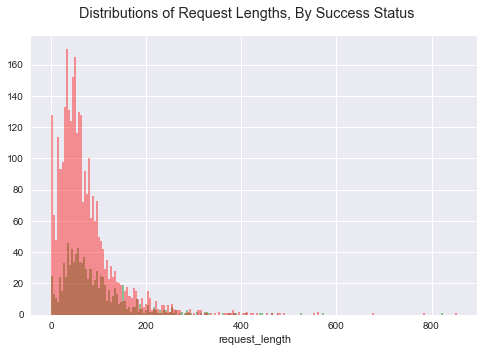

Results of Logistic Regression on Text Data 
              precision    recall  f1-score   support

   No pizza       0.76      0.81      0.78       762
  Got pizza       0.27      0.22      0.24       248

avg / total       0.64      0.66      0.65      1010



In [5]:
### Pull in text data
a = pd.read_json('train.json', orient='columns')
data_set = a[['request_text_edit_aware','request_title']]
text_data = pd.concat([df6_labels, data_set], axis = 1) 
data_labels = a['requester_received_pizza']
text_data['request_length'] = text_data['request_text_edit_aware'].map(lambda x: len(x.split()))
###########################################################################################
## Considering the effect of the length of a post

print('Average Length of Granted Request:', np.average(text_data[text_data['requester_received_pizza'] == True]['request_length']),
      '\nAverage Length of Failed Request:', np.average(text_data[text_data['requester_received_pizza'] == False]['request_length']))

bunny = text_data[text_data['requester_received_pizza'] == True]
bunny['request_length'] = bunny['request_text_edit_aware'].map(lambda x: len(x.split()))
np.average(bunny['request_length'])

jackal = text_data[text_data['requester_received_pizza'] == False]
jackal['request_length'] = jackal['request_text_edit_aware'].map(lambda x: len(x.split()))
np.average(jackal['request_length'])

import seaborn as sns
import math

#x = pd.Series(bunny['request_length'], name = 'request granted lenth')
#ax = sns.distplot(x)
sns.set(rc={"figure.figsize": (8, 5)});
fig, ax = plt.subplots()
sns.distplot(bunny['request_length'], ax=ax, color='green',kde=False, rug=False,bins=200)
sns.distplot(jackal['request_length'], ax=ax, color='red',kde=False, rug=False,bins=200)
plt.subplots_adjust(top=0.9)
fig.suptitle('Distributions of Request Lengths, By Success Status')
plt.legend(loc='upper left')
sns.plt.show()


def preprocess(x):
    """Use a series of regex expressions to remove unwanted characters"""
    #remove non-alpha-numeric characters, replace with whitespace
    x1 = re.sub(r'[^a-zA-Z_0-9_\s]'," ", x).lower()
    #replae all numbers with a single token and a space afterwards
    x1a = re.sub(r'[0-9]+', 'number ', x1)
    #x1b = re.sub(r'[_]+', ' ', x1a)
    #even though there are words that are just '_____', f1 actuall decreases when they're removed
    #remove newlines
    x2 = re.sub(r'[\n]', " ", x1a)
    #scrub out extra spaces
    x3 = re.sub(r'\s+', ' ', x2)  #other steps might have added extra space; remove
    return x3.strip()

sss = StratifiedShuffleSplit(test_size=0.25, random_state=1)
for train_index, test_index in sss.split(data_set, data_labels):
    X_train, X_test = data_set.iloc[train_index], data_set.iloc[test_index]
    y_train, y_test = data_labels.iloc[train_index], data_labels.iloc[test_index]

###########################################################################################

# Feature Union for post title and post text, w/ logistic regression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]


class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features


pipeline = Pipeline([
    # Extract the subject & body
    #('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('get-title', Pipeline([
                ('selector', ItemSelector(key='request_title')),
                ('cv', TfidfVectorizer(analyzer='char_wb', 
                                       #vocabulary=vocabulary,
                                       preprocessor=preprocess,
                                       max_df=0.5, ngram_range=(1,3)))
            ])),

            # Pipeline for standard bag-of-words model for body
            ('get-request', Pipeline([
                ('selector', ItemSelector(key='request_text_edit_aware')),
                ('cv', TfidfVectorizer(analyzer='char_wb', 
                                       #vocabulary=vocabulary,
                                       preprocessor=preprocess,
                                       max_df=0.5, ngram_range=(1,3)))
            ])),
            
           #('get-number', Pipeline([
           #     ('selector', ItemSelector(key='number'))
           # ]))

        ]
    )),

    # Use a SVC classifier on the combined features
    ('nb',LogisticRegression(penalty='l2',C=100)),
])


pipeline.fit(X_train, y_train)
text_pred = pipeline.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print("Results of Logistic Regression on Text Data \n", classification_report(y_test, text_pred, target_names=target_names))

#top_word_pairs = get_top_words(text_data['requester_received_pizza'], tkn2_request, fit2_req)
#print("\nPaired Word Frequency Matrix: Top Words per Article Type \n\t",', '.join(newsgroups_train.target_names))
#top_term_pairs = get_top_terms(top_word_pairs[0], top_word_pairs[1], fit2_req, text_data['requester_received_pizza'])

# Final Model and Error Analysis

### Reasoning for Ada Boost

The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire [FS1995].

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, ..., w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].

In [11]:
#best kaggle score
### add a stemmer
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
analyzer = TfidfVectorizer().build_analyzer()

### change the binarized test data to contain the same columns as the train data
#df6_cols = [x for x in df6_data.columns if x in tstdf6.columns]
ntstdf6 = pd.DataFrame(index=tstdf5.index)
for x in list(df6_data.columns):
    if x in tstdf5.columns:
        ntstdf6[x] = tstdf5[x]
    else:
        ntstdf6[x] = 0
ntstdf6.shape

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

tkn_request = TfidfVectorizer(preprocessor=preprocess,
                              stop_words='english',
                              #vocabulary=good_words,
                             analyzer = stemmed_words)
tkn_title = TfidfVectorizer(preprocessor=preprocess,
                            stop_words='english',
                           analyzer = stemmed_words)
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(text_data['request_title'])


from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        csr_matrix(feature_request),
        csr_matrix(feature_title),
        csr_matrix(df6_data), 
        csr_matrix(num_norm)), 
        format='csr')

y = text_data['requester_received_pizza']

# shuffle data
sss = StratifiedShuffleSplit(test_size=
                             0.20, random_state=1)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# implement ada boost classifier
ad2 = AdaBoostClassifier()
ad2.fit(X_train, y_train)
ad2_pred = ad2.predict(X_test)
print("Results for AdaBoost Implementation: \n", classification_report(y_test, ad2_pred, target_names=target_names))



# put in proper submission format
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')

# consider if number of answered requests for pizza is similiar to train data
np.average(Y_pred)

# verify format visually
fin_df.head()

# output to file
fin_df.to_csv('pizza_submission11.csv', header=True, index=False)


Results for AdaBoost Implementation: 
              precision    recall  f1-score   support

   No pizza       0.78      0.91      0.84       609
  Got pizza       0.46      0.23      0.31       199

avg / total       0.71      0.75      0.71       808



NameError: name 'vint' is not defined

In [56]:
confusion_matrix(y_true = y_test, y_pred =ad2_pred)

array([[556,  53],
       [153,  46]])

##  Appendix

Here you will miscellaneous techniques performed that did not necessarily inform the decision of the final model. This section may not be as organized as the rest of the notebook, but is included for posterity and possible usefulness in any future analysis. 

#### A bunch of random model tests

In [61]:
model1 = LogisticRegression()
model1.fit(X, y)
y_pred = model1.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.92      1.00      0.96      3046
  Got pizza       1.00      0.72      0.84       994

avg / total       0.94      0.93      0.93      4040



In [65]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
modeldt = DecisionTreeClassifier()
modeldt.fit(X_train, y_train)
y_pred = modeldt.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.78      0.77      1006
  Got pizza       0.29      0.28      0.28       328

avg / total       0.65      0.66      0.65      1334



             precision    recall  f1-score   support

   No pizza       1.00      1.00      1.00      3046
  Got pizza       1.00      1.00      1.00       994

avg / total       1.00      1.00      1.00      4040

